# Automatic event detection code from Pspice circuits data
### Author: José Eduardo Alves Pereira Filho
### Institution: FEEC/UNICAMP

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import warnings
from scipy import signal
from scipy.fft import fftshift
warnings.filterwarnings("ignore", category=FutureWarning)

## CHANGE DIRECTORY !

In [2]:
# I'll let the folder containing the testing circuits inside the current folder and it is named Circuits
cwd = os.getcwd()
PATH_CIRCUITS = os.path.join(cwd, 'Circuits')
global PATH_IMAGES
PATH_IMAGES = os.path.join('\\'.join(PATH_CIRCUITS.split('\\')[:-2]),'Imagens')

## Function definitions

In [3]:
def pspice2numpy(PATH):
    
    # Open the file in the PATH and capture all lines in a list
    with open(PATH, 'r') as f:
        lines = f.readlines()
    
    # Initializate iterators 
    t = []
    measures = []
    lista = iter(lines)
    line = next(lista, False)
    
    # While there is a line containing strings keep checking for valures 
    while line:
        # In PSPICE code, '#C' lines contain the information of the timestamp of the values in the line below as well as how many valures to expect
        if line[0:2] == '#C':
            values = re.split("\s", line)
            t.append(float(values[1]))
            
            # After getting the information about time, get the values in the next line 
            # The vlaues are written as Value1:1 Value2:2 ... Valuen:n 
            line = next(lista, False)
            measures.append([float(x) for x in re.findall("([\d\+-\.E]+):", line)])
        line = next(lista, False) 

    return [t, np.array(measures).T]

def get_data(PATH_CIRCUITS):
    """
    Data {
        'key' : [vetor de tempo, matrix de dados por node coletado]
        }
    """
    Data = {}
    # List of circuits in the folder
    for file in os.listdir(PATH_CIRCUITS):
        x = file.split('.')
        # Only .csd elements are readable, so convert them into [time, [vector1,vector2,...,vectorn]]
        # And add them to the Data dictionary name_of_file: [time, [vector1,vector2,...,vectorn]]
        if x[-1] == 'csd':
            Data[x[0].split('_')[0]] = pspice2numpy(os.path.join(cwd, 'Circuits',file))
    return Data
        
def Active_Power(t, I, V, f = 60, padding = None, speedup = False):
    A = []
    T = 1/f
    total_points = len(t)
    
    # The true time step between each point 
    step = (t[-1]-t[0])/total_points
    # Window to sum the instant power to get the active power after division of the period
    start = int(T//step)
    
    # Instant power each second
    P = V*I
    if padding is not None:
        P = np.concatenate((np.zeros(start), P),axis=0)
        total_points = len(P)
        
    if speedup:
        pass # TODO
        # P0 = np.sum(P[0:start])/start
        # A.append(P0)
        # for 
    else:
        for i in range(start, total_points, 1):
            A.append(np.sum(P[i-start:i])/start)
        
    return np.array(A)

def process_data(PATH_CIRCUITS, pad = True):
    data = get_data(PATH_CIRCUITS)
    graphs = {}
    """
        key: [t, V, I, A]
    """
    for key,value in data.items():
        t = value[0]
        V = value[1][0]
        I = value[1][1]
        A = Active_Power(t, I, V, f = 60, padding = pad)
        graphs[key] = [np.array(t),np.array(V),np.array(I),A]
        
    return graphs

def plot_results(all_data, PATH_IMAGES):
    for key in all_data.keys():
        t = all_data[key][0]
        V = all_data[key][1]
        I = all_data[key][2]
        A = all_data[key][3]

        plt.figure(figsize = (15,15))

        plt.subplot(3,1,1)
        plt.plot(t,V, color = 'b')
        plt.title('Tensão para o '+ key, loc='left',fontsize=18,)
        plt.xlabel('Tempo em segundos (s)')
        plt.ylabel('Tensão (V)')

        plt.subplot(3,1,2)
        plt.plot(t,I,color = 'r')
        plt.title('Corrente para o '+ key, loc='left',fontsize=18)
        plt.xlabel('Tempo em segundos (s)')
        plt.ylabel('Corrente (A)')

        plt.subplot(3,1,3)
        plt.plot(t,A/1000, color = 'k')
        plt.title('Potência ativa para o '+ key, loc='left',fontsize=18)
        plt.xlabel('Tempo em segundos (s)')
        plt.ylabel('Potência (kW)')

        plt.savefig(PATH_IMAGES+'\\'+key+'.png', bbox_inches='tight')
        plt.close()
        
    return None

#Return the size of the PWM window and the time when it was high
def PWM_verifier(signal):
    
    # Transform X axis into Y axis 
    y = np.linspace(0,len(signal),len(signal))*np.squeeze(np.array(signal))
    
    i = 0
    PWMs = []
    try:
        while i  < len(y):
            aux = [0,0]
            # When the value is different from 0, get the initial time of the window
            if y[i] != 0:
                m = y[i]
                aux[0] = i 
                # When the value is equal to 0 again, get the final time of the window
                while y[i] != 0:
                    i += 1 
                M = y[i-1]
                aux[1] = i-1
                PWMs.append([M-m,aux])
            i += 1
    except:
        pass
    return PWMs 

def circuit1_gt():
    plt.axvline(x = 35000, color = 'r', linestyle = '--')
    plt.axvline(x = 52000, color = 'r', linestyle = '--')
    plt.axvline(x = 60000, color = 'r', linestyle = '--')
    
def circuit2_gt():
    plt.axvline(x = 52000, color = 'r', linestyle = '--')
    plt.axvline(x = 67000, color = 'r', linestyle = '--')
    plt.axvline(x = 70000, color = 'r', linestyle = '--')
    
def circuit3_gt():
    plt.axvline(x = 51000, color = 'r', linestyle = '--')
    plt.axvline(x = 55000, color = 'r', linestyle = '--')
    plt.axvline(x = 56000, color = 'r', linestyle = '--')
    
def circuit4_gt():
    plt.axvline(x = 51000, color = 'r', linestyle = '--')
    plt.axvline(x = 70000, color = 'r', linestyle = '--')
    
def circuit5_gt():
    plt.axvline(x = 52000, color = 'r', linestyle = '--')
    plt.axvline(x = 67000, color = 'r', linestyle = '--')
    plt.axvline(x = 94000, color = 'r', linestyle = '--')

def plot_gt(key):
    if key == 'Circuito1':
        circuit1_gt()
    elif key == 'Circuito2':
        circuit2_gt() 
    elif key == 'Circuito3':
        circuit3_gt() 
    elif key == 'Circuito4':
        circuit4_gt() 
    elif key == 'Circuito5':
        circuit5_gt() 
    else:
        print("Circuit not found.")
        
def SMA(W_usec,V,I,t):
    
    df = pd.DataFrame(V*I)
    
    # Sampling frequency 
    fa = int(len(t)/(t[-1]-t[0])/10**6)

    W = int(W_usec*fa)

    sma = df.rolling(window=W).mean().fillna(0)
    
    return sma

def verifier(events,time_window):
    PWM = PWM_verifier(events)

    for i in range(0,len(PWM)-1):

        # print("-------------------------------")
        # print(PWM[i][0])
        # print(PWM[i+1][0])

        if np.abs(PWM[i][0] - PWM[i+1][0]) > 500:
            print(f"Pode ter acontencido um evento entre {(PWM[i][1][1]-time_window[1])/1000} e {(PWM[i+1][1][0]-time_window[1])/1000} ms")
            
def SMA_analysis(all_data, save = False):
    
    for key in all_data.keys():

        t = all_data[key][0]
        V = all_data[key][1]
        I = all_data[key][2]
        A = all_data[key][3]

        time_window = [7371,16733] # microseconds = Points (fa = 1MHz)

        fast = SMA(time_window[0],V,I,t)
        slow = SMA(time_window[1],V,I,t)

        # When fast mean is higher than slow mean, maybe there was a event
        events = fast.values-slow.values > 2

        # Normalized fast and slow
        fast = fast/np.max(fast)
        slow = slow/np.max(slow)

        plt.figure(figsize = (15,7))
        plt.plot(fast, label = "Filtro de 60Hz (rapido)")
        plt.plot(slow, label = "Potência Ativa (lento)")
        plt.plot(events,  color = 'k', linestyle = '-', label = "Rapido > Devagar") # quando a media RAPIDA é maior que a media LENTA 
        plot_gt(key)
        plt.title(key)
        plt.xlabel("Tempo (us)")
        plt.ylabel("Sinais normalizados")
        plt.legend()
        
        if save:
            plt.savefig(PATH_IMAGES+'\\'+key+'_SMA.png', bbox_inches='tight')
            plt.close()
        else:
            plt.show()
        print(key)
        verifier(events,time_window)
        print("-------------------------") 
        
def spec_3D_plot(t, Sxx, freq = [5,10,30], save = False, ke = "", fs = 10**6, t_reso = 10**-3):

    fig = plt.figure(figsize = (14,14))
    ax = fig.add_subplot(projection='3d')

    for k in freq:

        ax.plot(1000*t, Sxx[:][k]/np.max(Sxx[:][k]), zs=k, zdir='y', color='k', alpha=0.7)

    ax.set_xlabel('Tempo (ms)')
    ax.set_ylabel('Intervalo de frequencia(x'+str(int(fs/t_reso))+')')
    ax.set_zlabel('Intensidade normalizada')
    
    # Show onoly the desired frequencies
    ax.set_yticks(freq)
    
    if save:
        plt.savefig(PATH_IMAGES+'\\'+ke+'_3D_frequency_plot.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    
def plot_detections_power(Sxx, freqs, time_resolution, overlaping, t, V, I, A, peak_precision=0.05, save = False, ke = ""):

    add_high_freq = np.zeros(len(Sxx[:][0]))
    for k in freqs:
        add_high_freq += Sxx[:][k]/np.max(Sxx[:][k])

    peaks, _ = signal.find_peaks(add_high_freq,  prominence=peak_precision)
    p = [round(ele - ele/(time_resolution/overlaping)) for ele in peaks]

    plt.figure(figsize = (15,7))
    plt.plot(t,A)
    for peak in range(len(p)):
        plt.axvline(x = p[peak]/1000, linestyle = '--', color='r', label=f'{p[peak]} ms')
    plt.legend()
    plt.ylabel("Potência (W)")
    plt.xlabel("Tempo (s)")
    plt.title("Detecções")
    if save:
        plt.savefig(PATH_IMAGES+'\\'+ke+'_Power_detections.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    # for peak in p:
    #     print(f'Evento encontrado em {peak} ms')
    return p

def plot_spec(t_spec, f, Sxx, save = False, ke = ""):
    plt.figure(figsize = (15,7))
    plt.pcolormesh(t_spec, f[0:10], Sxx[:][0:10], shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if save:
        plt.savefig(PATH_IMAGES+'\\'+ke+'_spectrogram.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def spectrogram_analyisis(all_data, sv = False, freqs = [5,10,30], inp = 'I', win = signal.windows.hann(1000, sym=True), t_reso = 10**3, overlap_factor =  8):
    
    for key in all_data.keys():
        t = all_data[key][0]
        V = all_data[key][1]
        I = all_data[key][2]
        A = all_data[key][3]
        
        fs = len(t)/(t[-1]-t[0])
        N = len(t)
        t_reso = 10**3
        overlap = t_reso // overlap_factor
        
        if inp == 'I':
            f, t_spec, Sxx = signal.spectrogram(I, fs, window = win,  noverlap = overlap)
        elif inp == 'V':
            f, t_spec, Sxx = signal.spectrogram(V, fs, window = win,  noverlap = overlap)
        elif inp == 'A':
            f, t_spec, Sxx = signal.spectrogram(A, fs, window = win,  noverlap = overlap)
        else:
            raise ValueError(f'{inp} is not allowed. Only Current (I), Tension (V) or Active Power (A) are allowed.')
        
        plot_spec(t_spec, f, Sxx, save = sv, ke = key)
        
        spec_3D_plot(t_spec, Sxx, freq = freqs, save = sv, ke = key, fs = fs, t_reso = t_reso)
        
        peaks = plot_detections_power(Sxx, freqs, t_reso, overlap, t, V, I, A, peak_precision=0.05, save = sv, ke = key)
        
        print(key)
        for peak in peaks:
            print(f"Pode ter acontencido um evento em {peak} ms")
        print('-------------------')

## Getting data 

In [4]:
all_data = process_data(PATH_CIRCUITS, pad = True)

In [5]:
plot_results(all_data,PATH_IMAGES)

## Start Analysis

### Using "PWM"

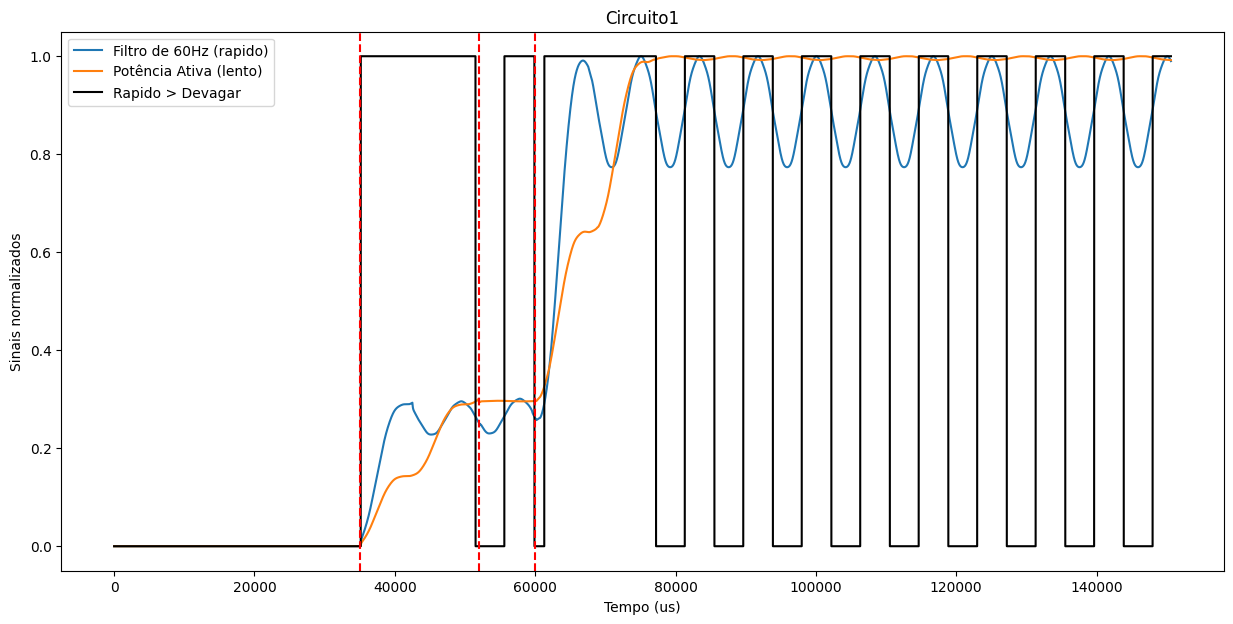

Circuito1
Pode ter acontencido um evento entre 34.76 e 38.874 ms
Pode ter acontencido um evento entre 43.152 e 44.564 ms
Pode ter acontencido um evento entre 60.478 e 64.587 ms
-------------------------


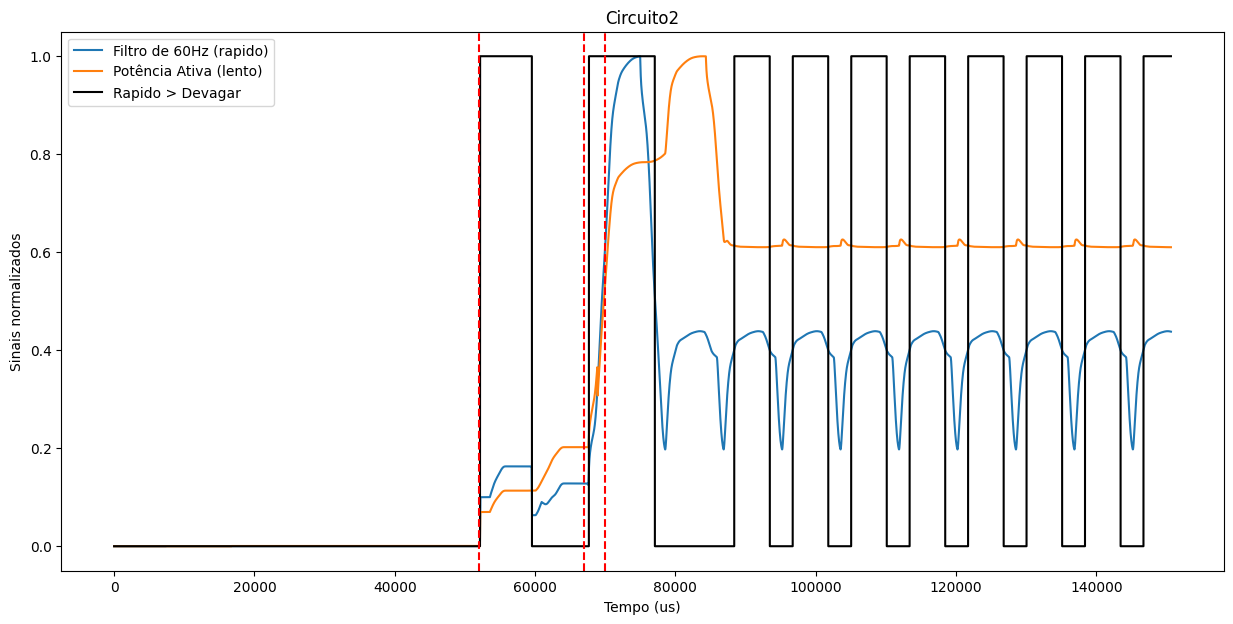

Circuito2
Pode ter acontencido um evento entre 42.811 e 50.939 ms
Pode ter acontencido um evento entre 60.332 e 71.659 ms
-------------------------


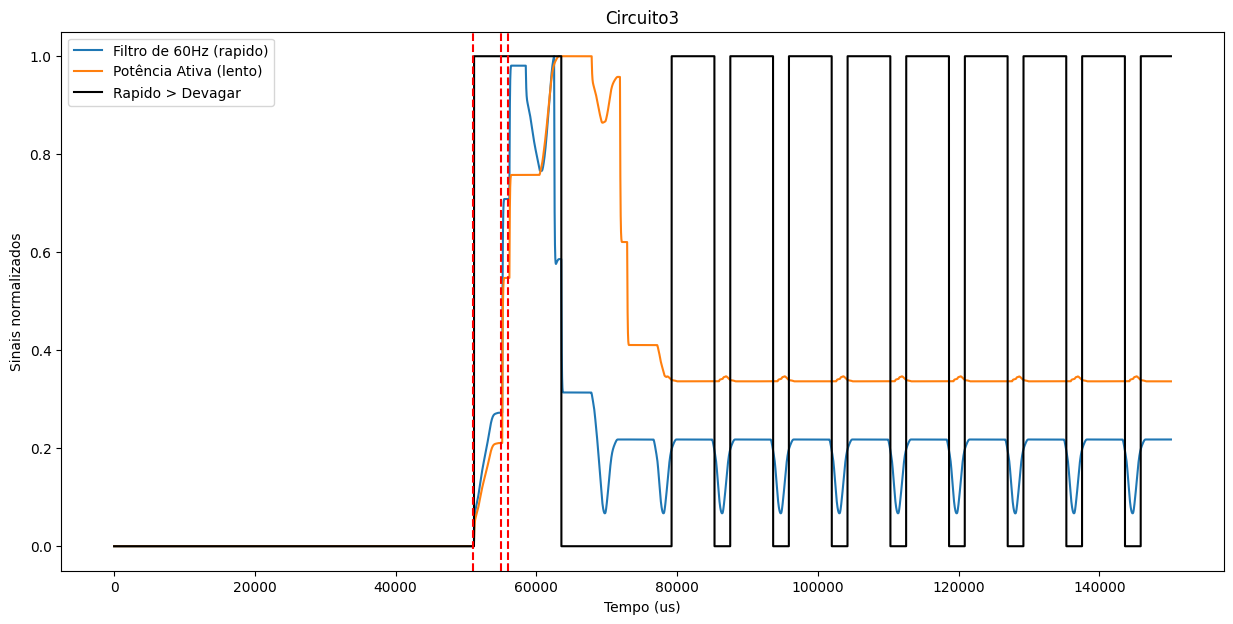

Circuito3
Pode ter acontencido um evento entre 46.816 e 62.489 ms
-------------------------


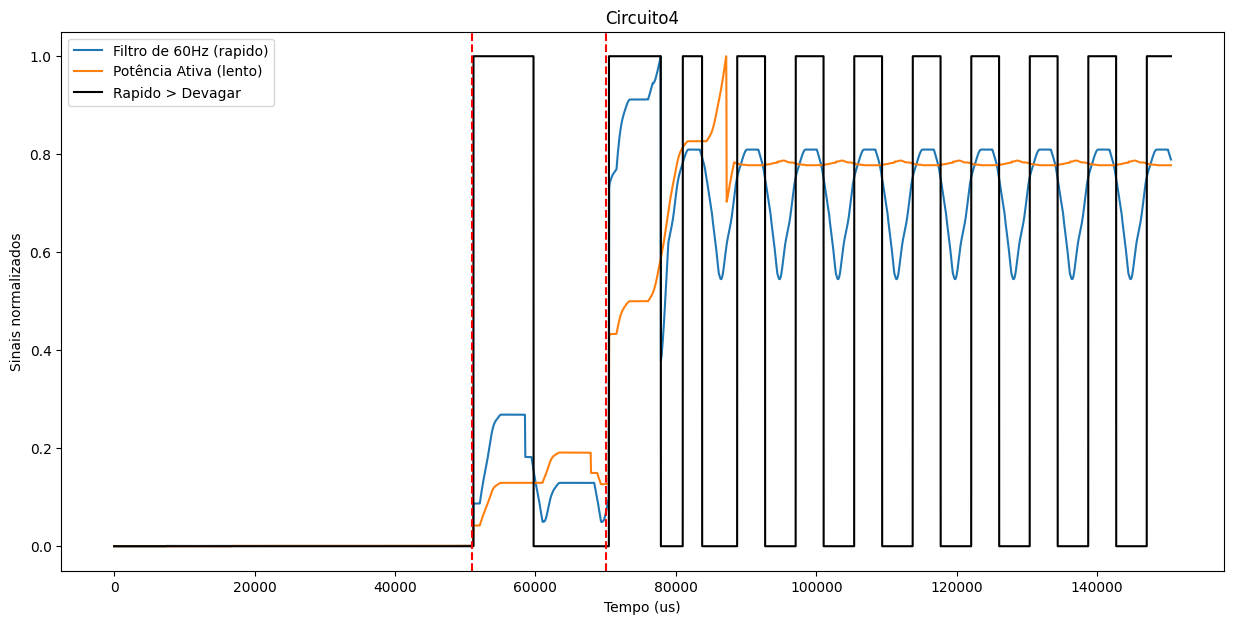

Circuito4
Pode ter acontencido um evento entre 42.994 e 53.727 ms
Pode ter acontencido um evento entre 61.119 e 64.244 ms
Pode ter acontencido um evento entre 66.997 e 71.993 ms
-------------------------


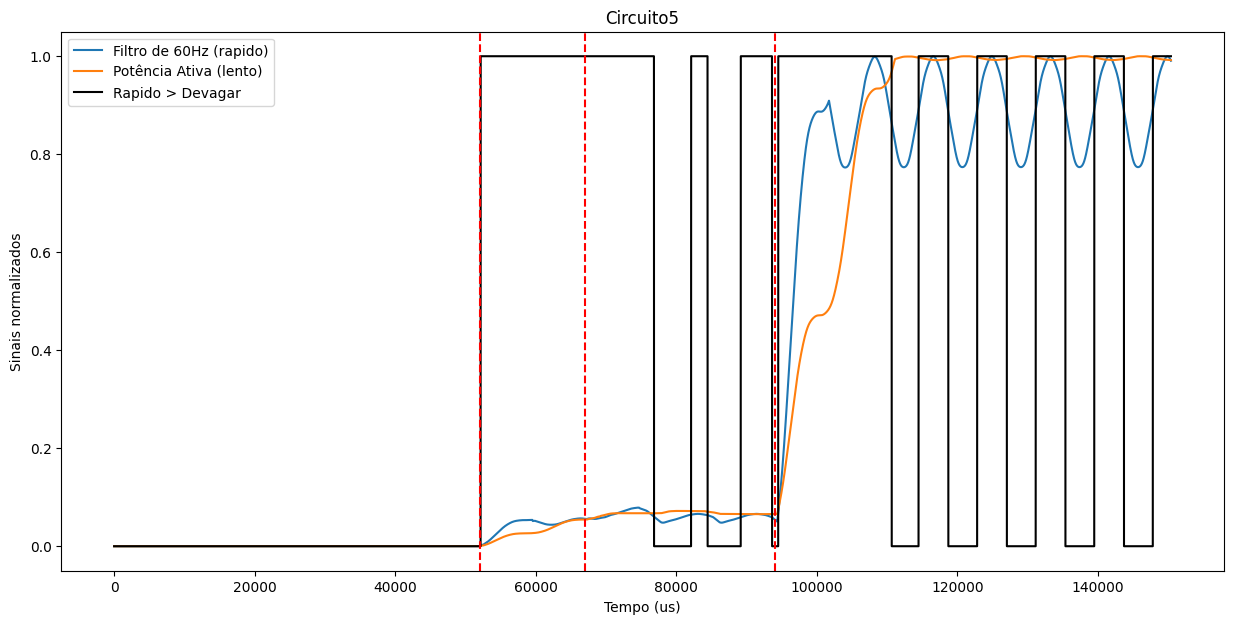

Circuito5
Pode ter acontencido um evento entre 60.091 e 65.373 ms
Pode ter acontencido um evento entre 67.716 e 72.439 ms
Pode ter acontencido um evento entre 76.889 e 77.773 ms
Pode ter acontencido um evento entre 93.916 e 97.746 ms
-------------------------


In [6]:
SMA_analysis(all_data, save = False)

### Spectrogram of the current (high frequency analysis)

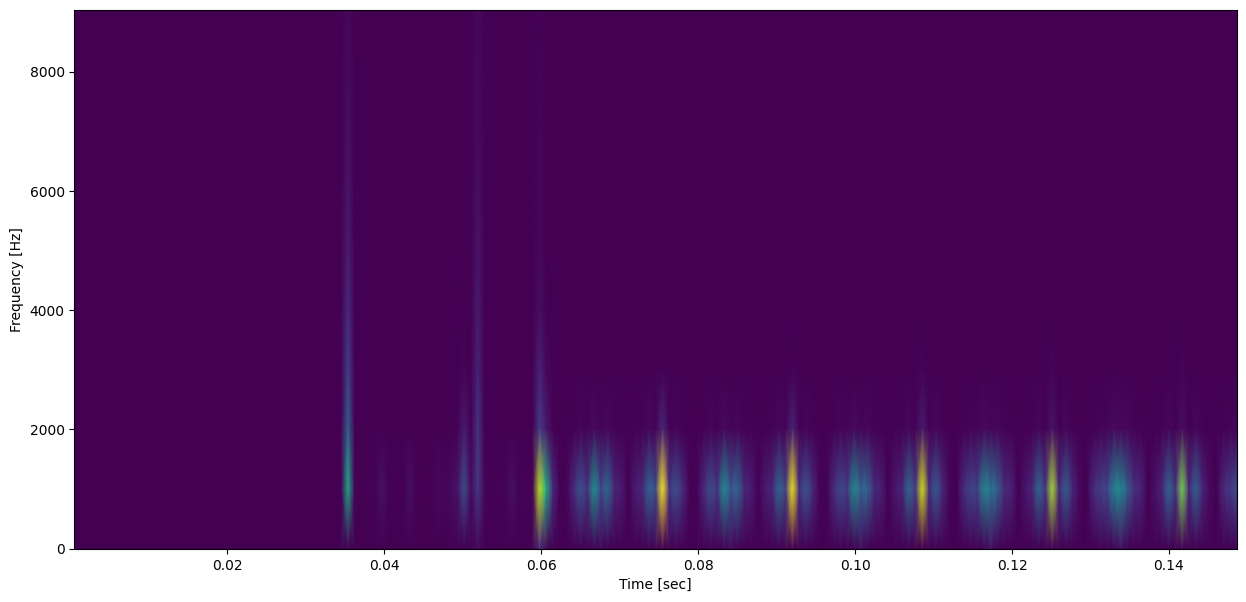

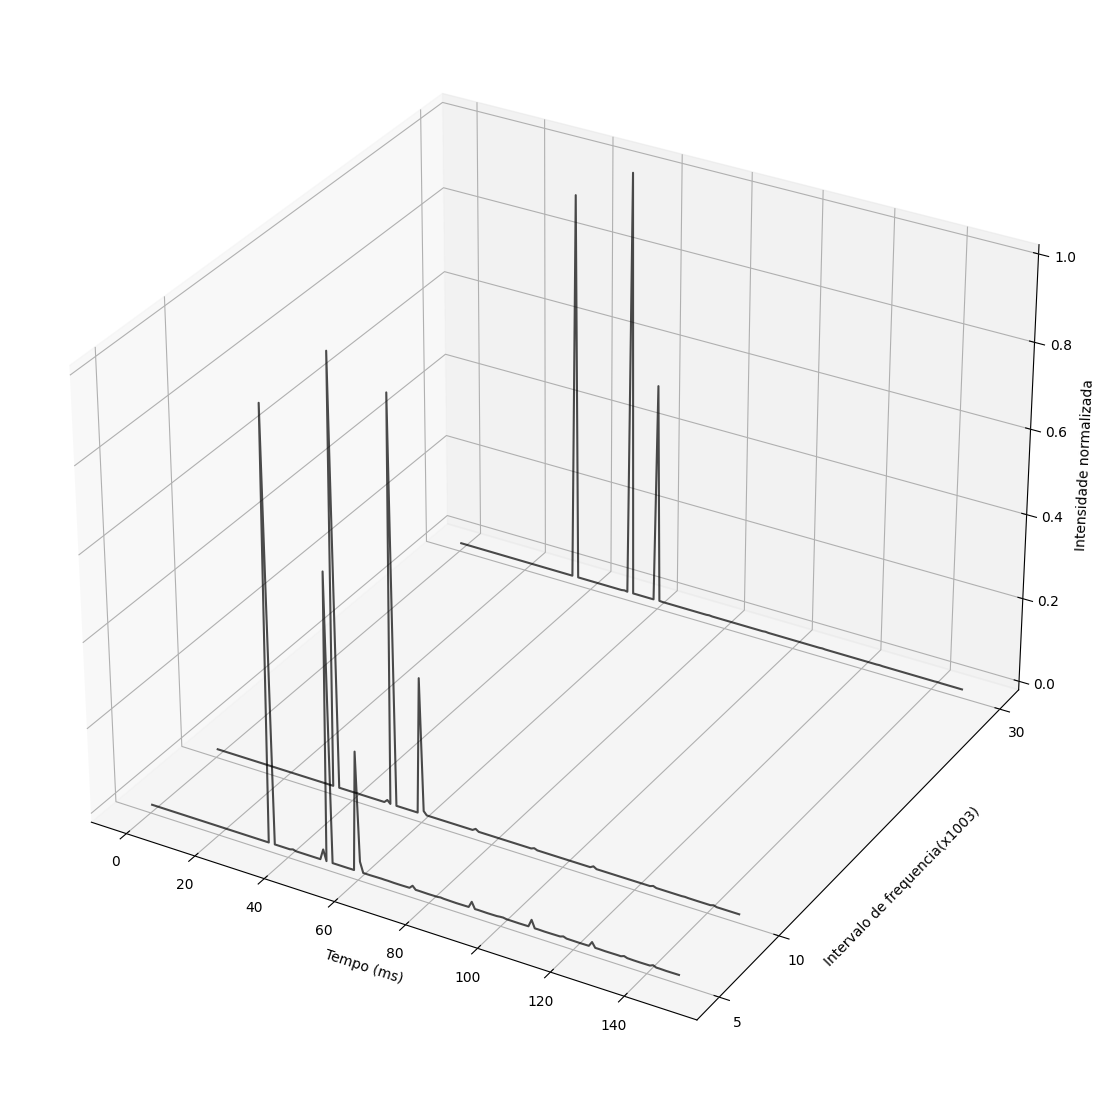

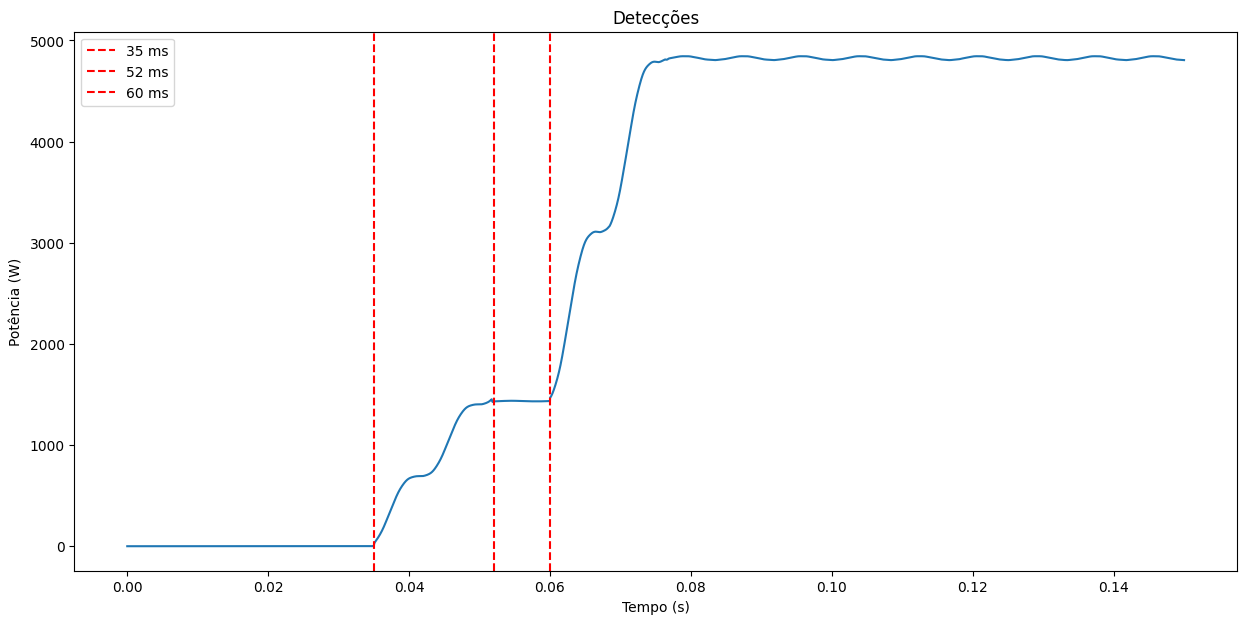

Circuito1
Pode ter acontencido um evento em 35 ms
Pode ter acontencido um evento em 52 ms
Pode ter acontencido um evento em 60 ms
-------------------


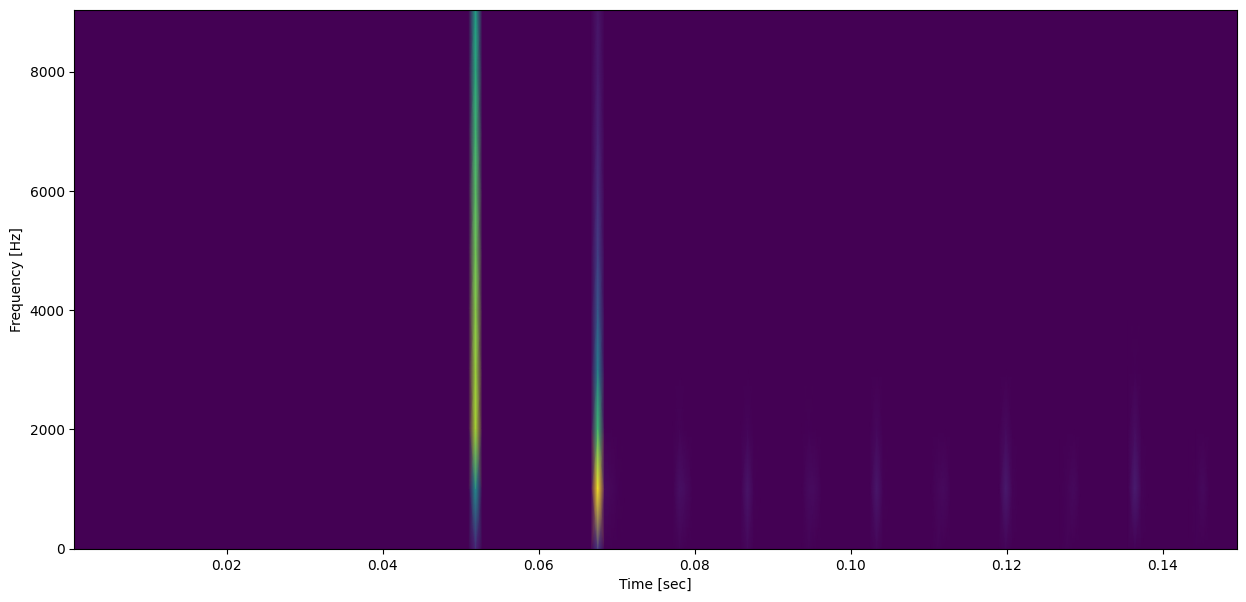

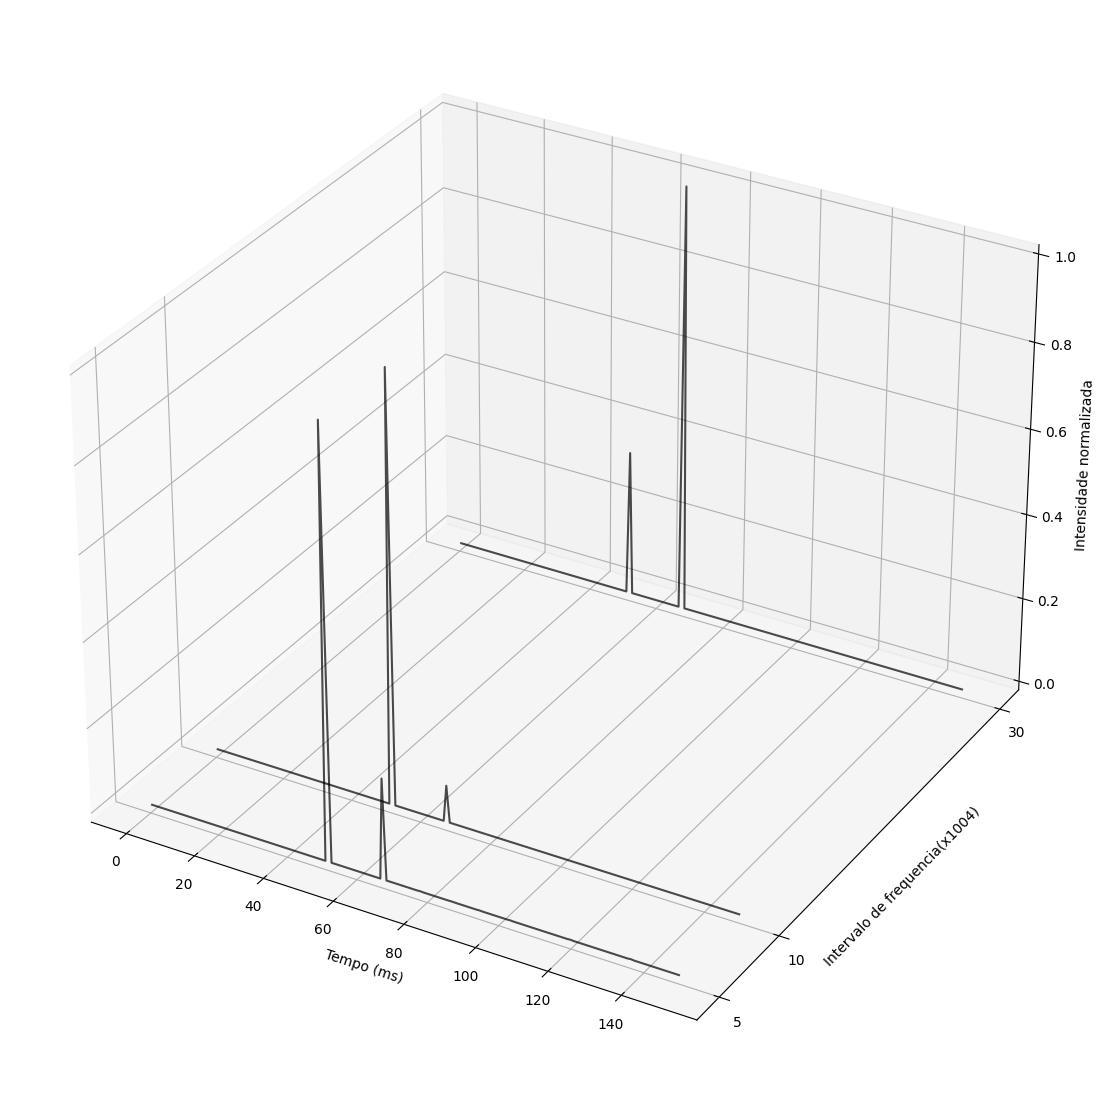

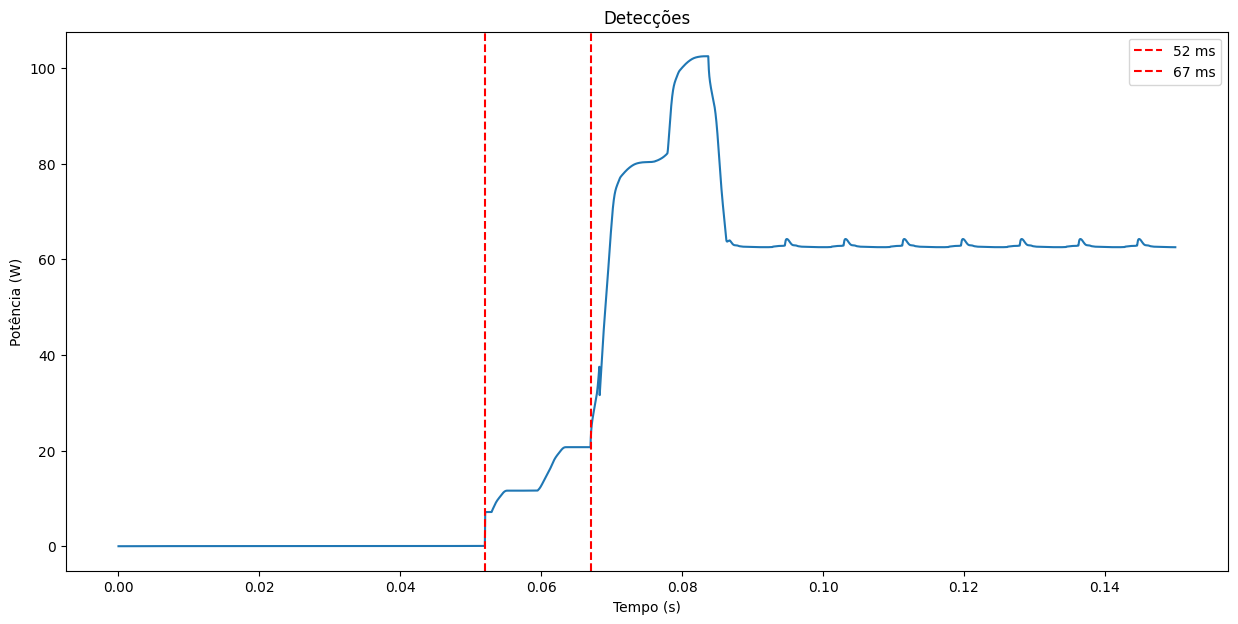

Circuito2
Pode ter acontencido um evento em 52 ms
Pode ter acontencido um evento em 67 ms
-------------------


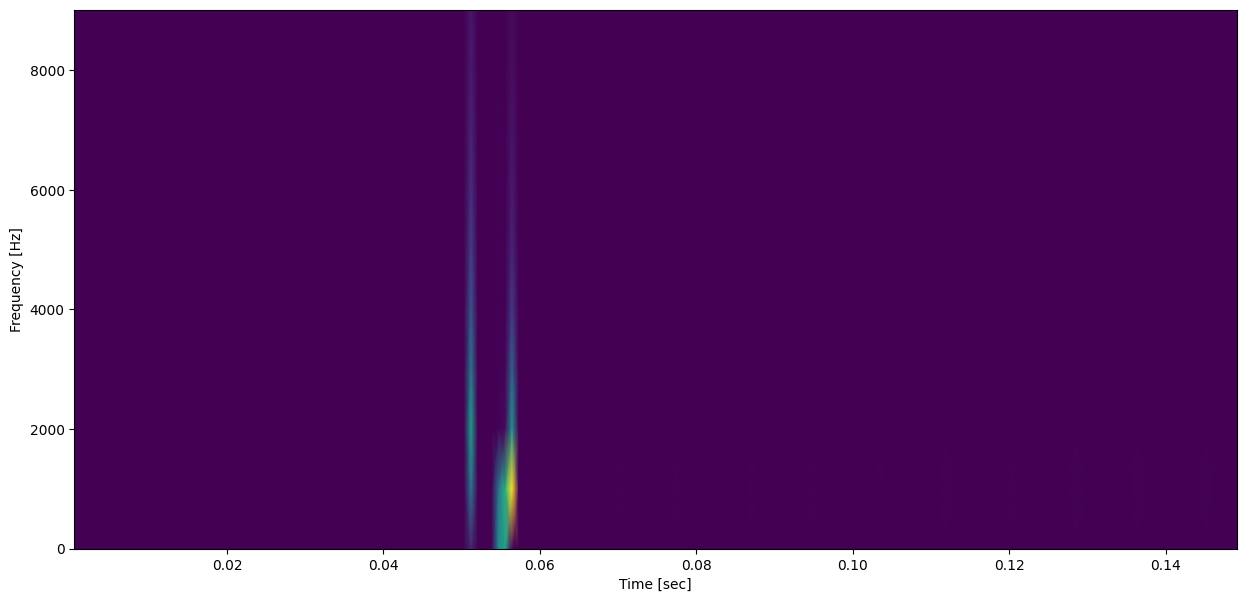

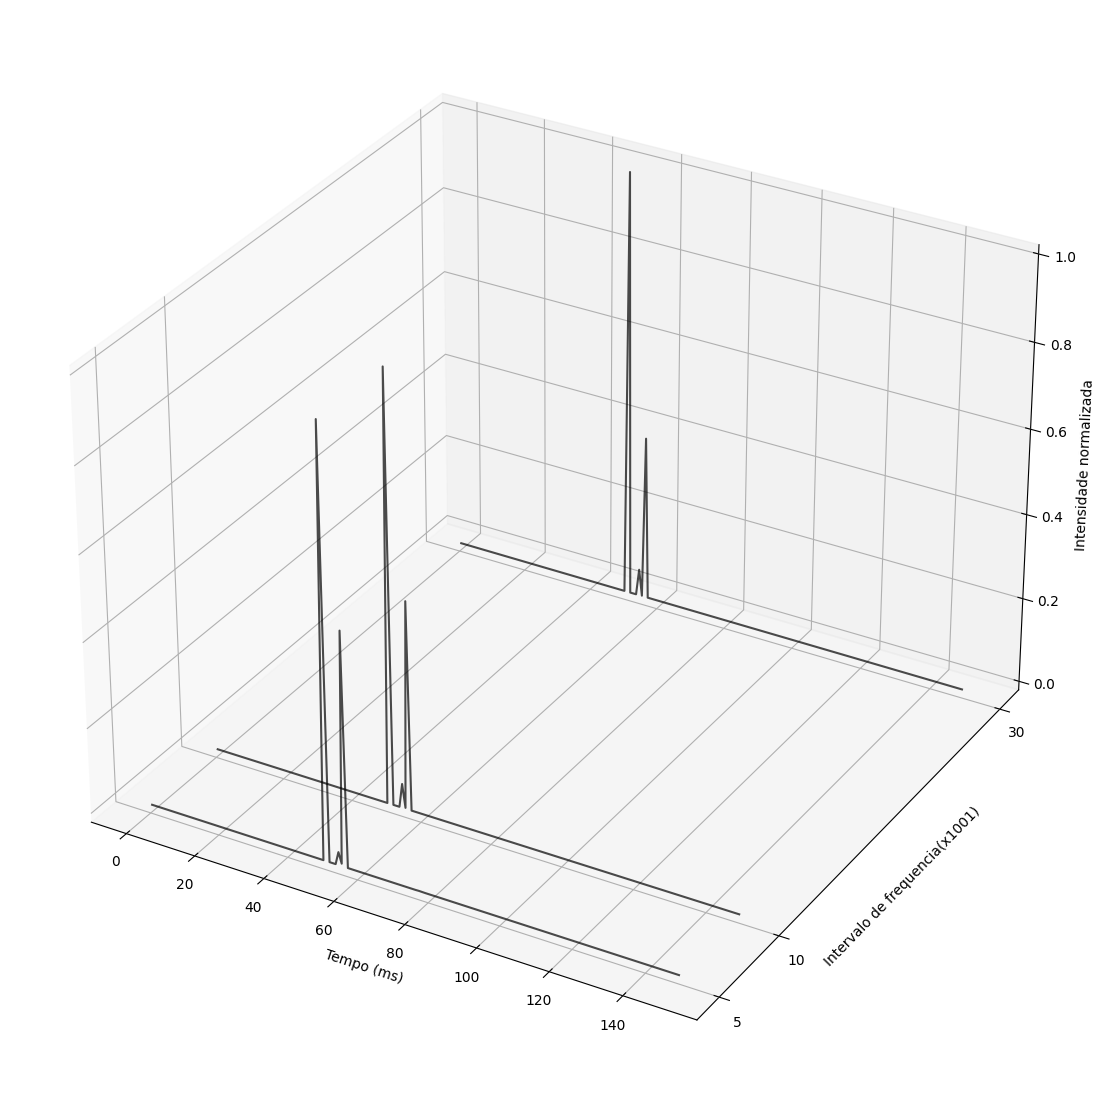

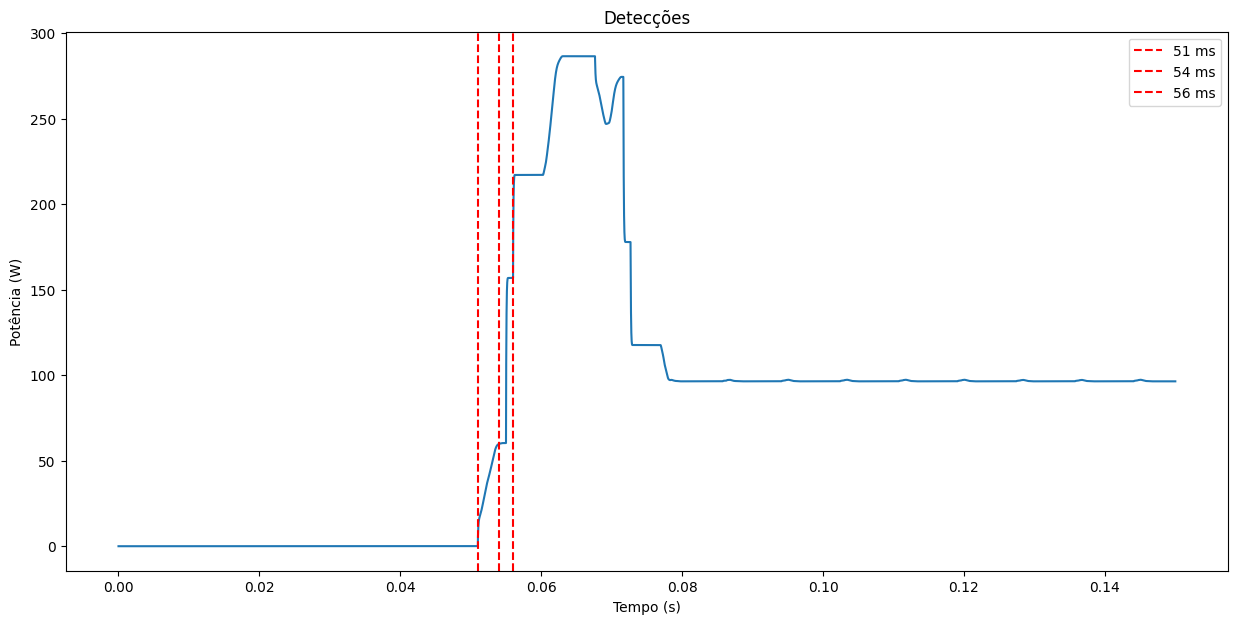

Circuito3
Pode ter acontencido um evento em 51 ms
Pode ter acontencido um evento em 54 ms
Pode ter acontencido um evento em 56 ms
-------------------


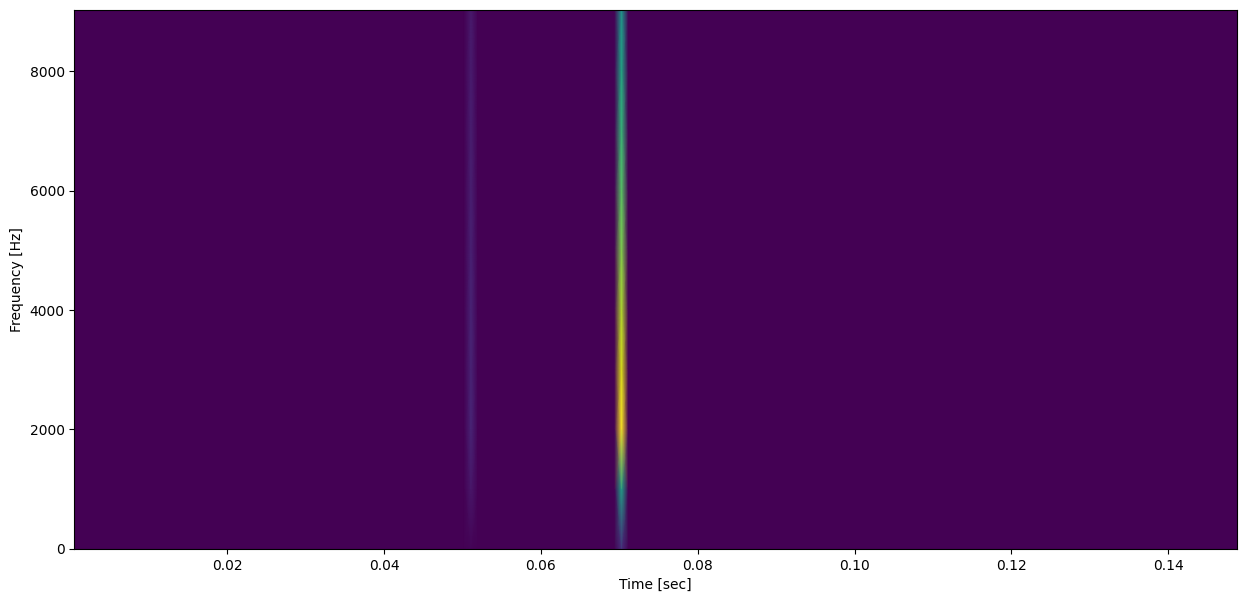

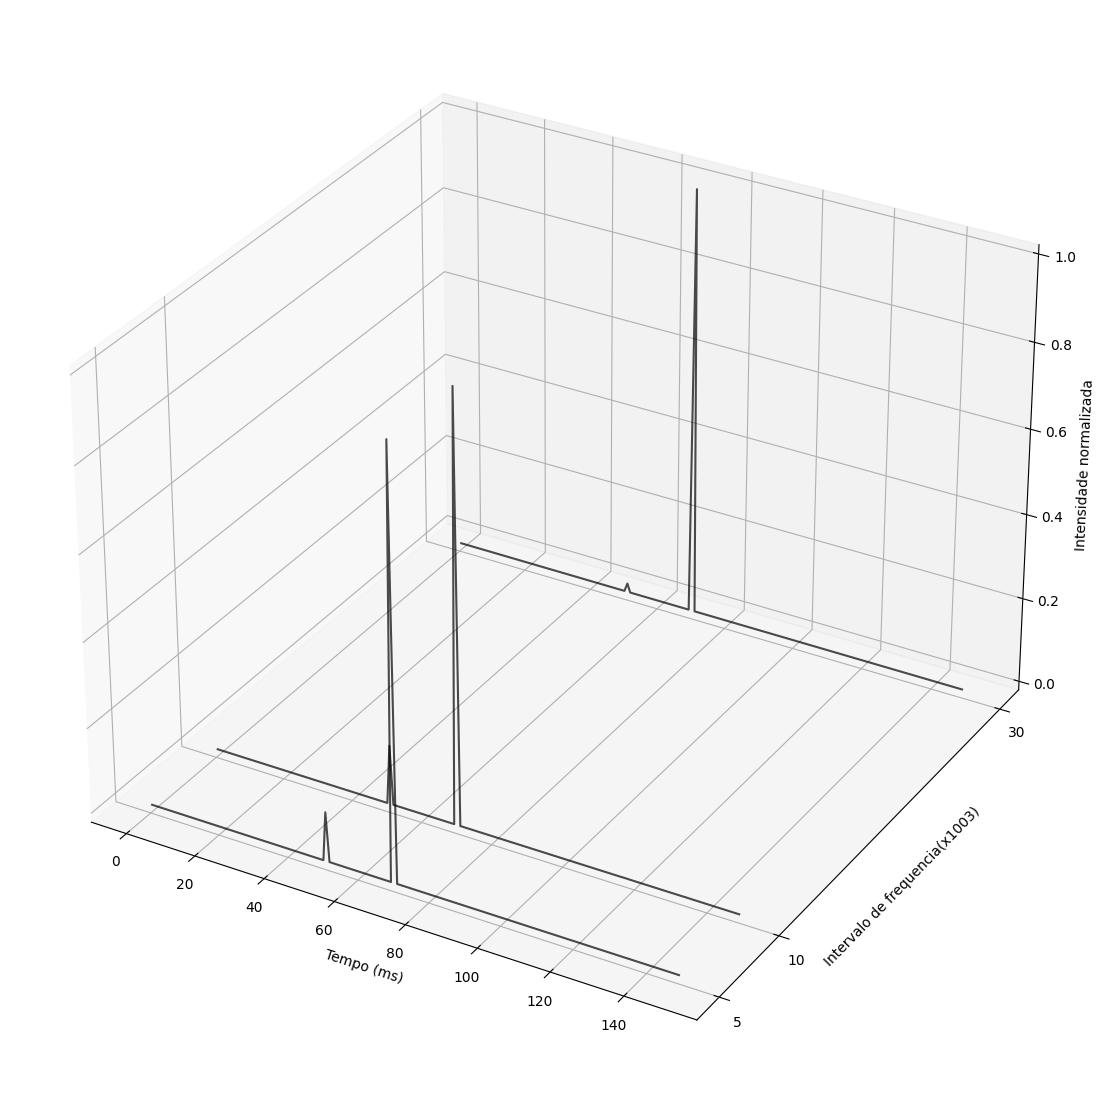

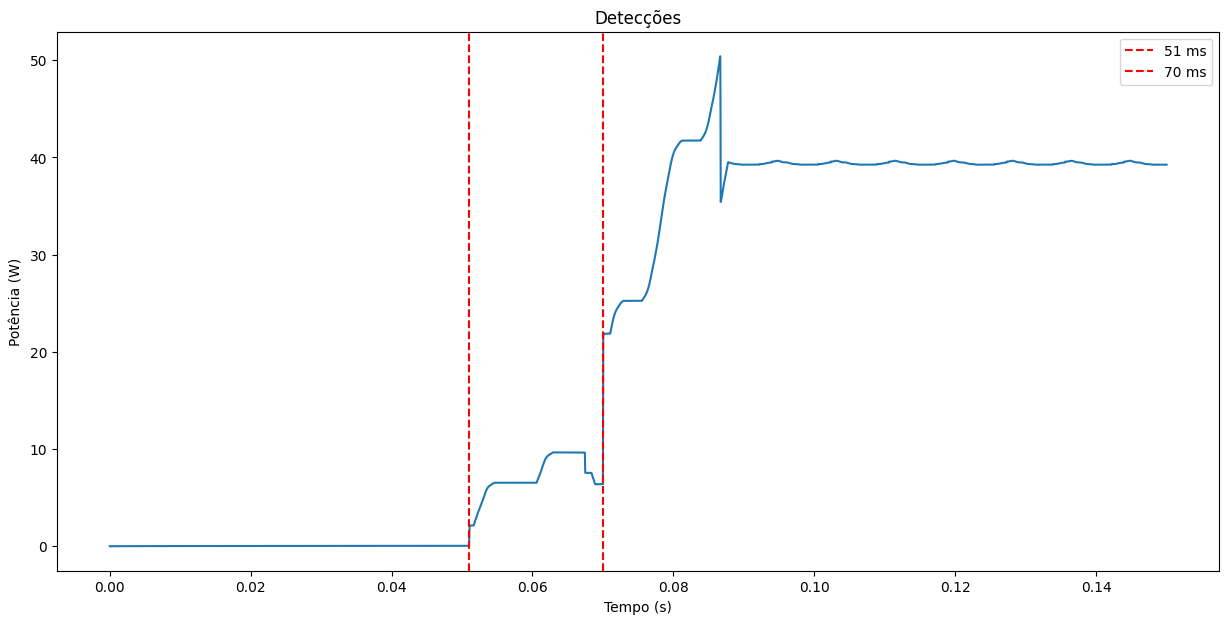

Circuito4
Pode ter acontencido um evento em 51 ms
Pode ter acontencido um evento em 70 ms
-------------------


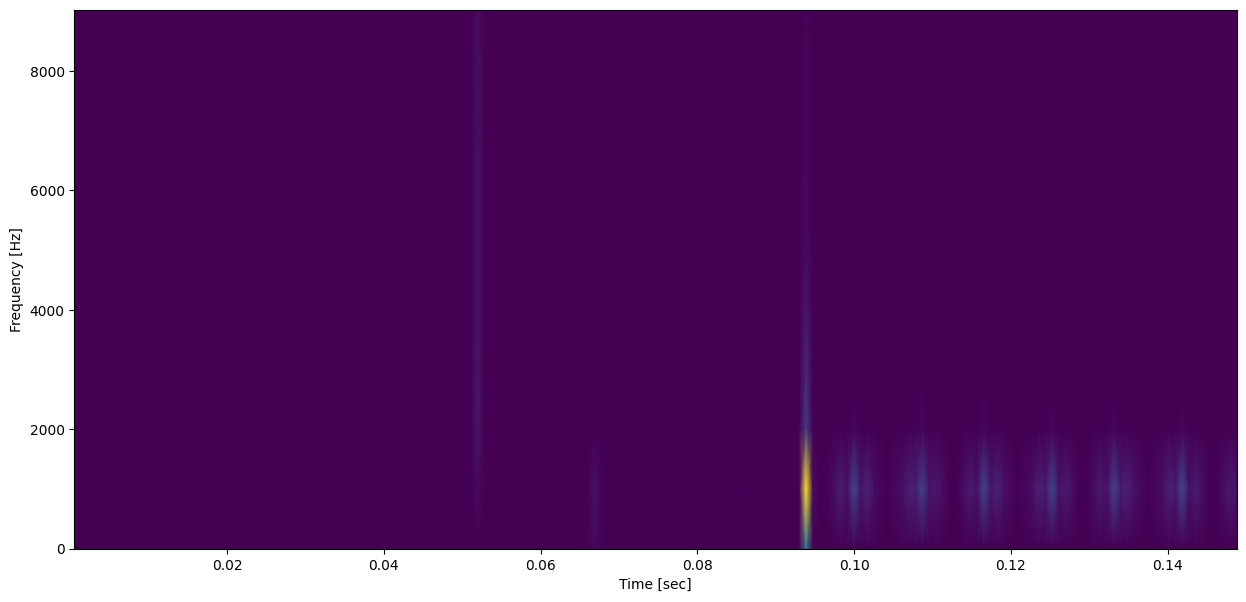

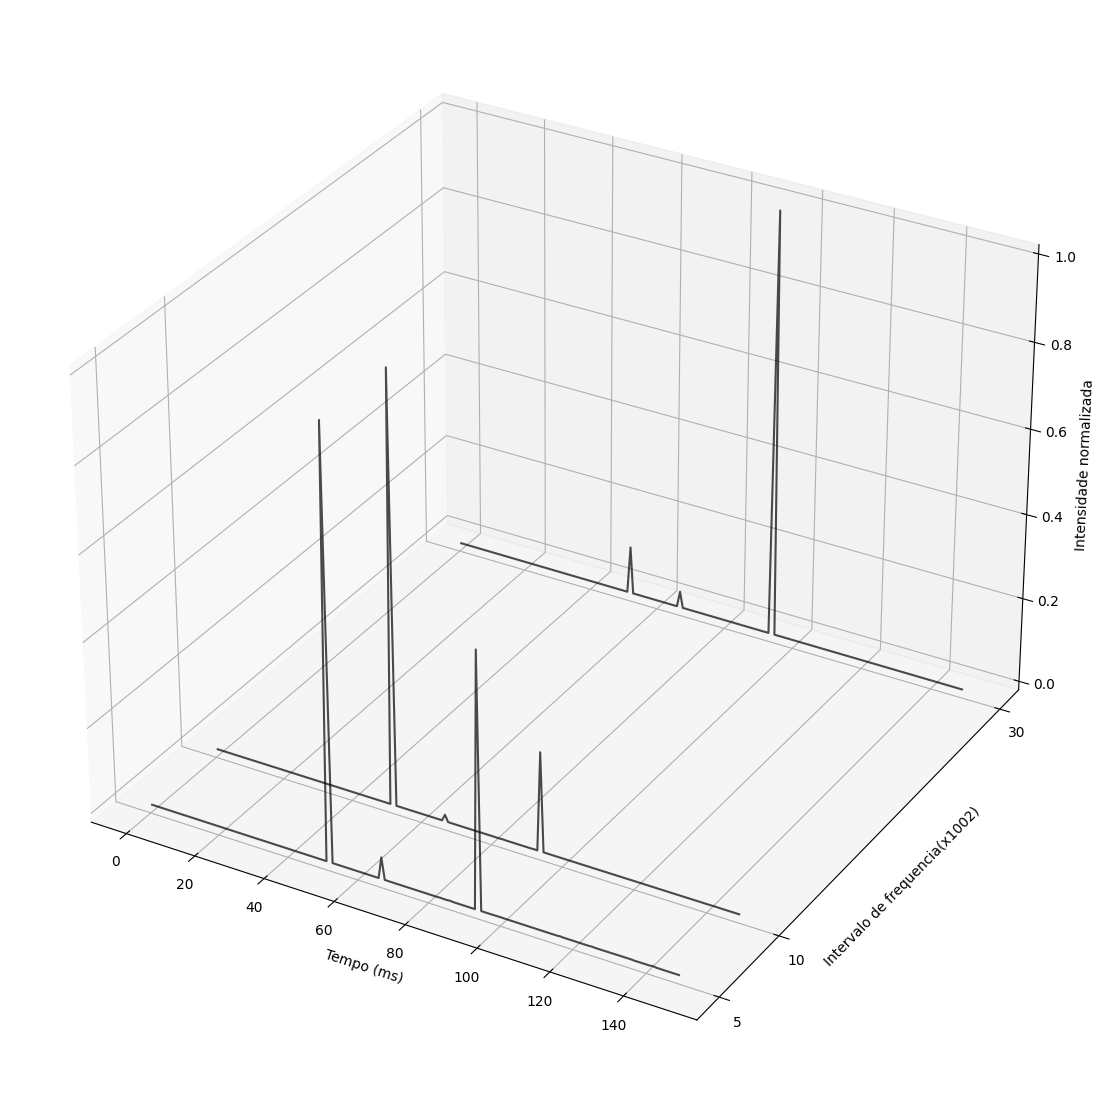

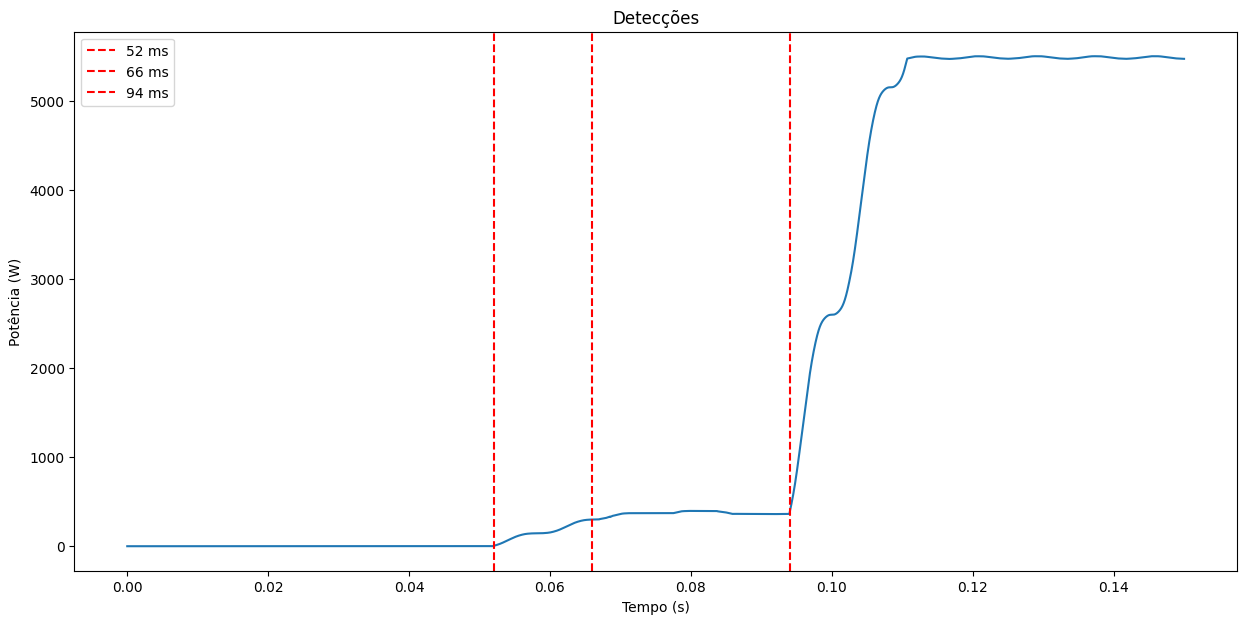

Circuito5
Pode ter acontencido um evento em 52 ms
Pode ter acontencido um evento em 66 ms
Pode ter acontencido um evento em 94 ms
-------------------


In [7]:
time_reso = 10**3
overlap =  8
window = signal.windows.hann(time_reso, sym=True)
spectrogram_analyisis(all_data,  sv = False, inp = 'I', win = window, t_reso = time_reso, overlap_factor =  overlap)